# Sentiment Analysis Pipeline
Notebook này thực hiện toàn bộ quy trình từ xử lý dữ liệu thô đến training và đánh giá model

In [26]:
import sys
import os

# Add project root to path
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Import các module cần thiết
from src.config import Config
from src.data.data_loader import DataLoader
from src.data.preprocessor import DataPreprocessor 
from src.features.feature_engineering import FeatureExtractor
from src.models.model_trainer import EnhancedModelTrainer
from src.models.model_predictor import SentimentPredictor
from src.utils.evaluation import ModelEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## 1. Cấu hình và Khởi tạo

In [27]:
# Khởi tạo config
config = Config()

# Chọn ngôn ngữ
language = 'vi'  # hoặc 'en'

# Khởi tạo các component
data_loader = DataLoader(config)
preprocessor = DataPreprocessor(language, config)
feature_extractor = FeatureExtractor(language, config)
model_trainer = EnhancedModelTrainer(language, config)
evaluator = ModelEvaluator(language)

Loaded feature extractor with None dimensions


## 2. Load và Xử lý Dữ liệu

In [28]:
# Load raw data
df = data_loader.load_data(language)

# Hiển thị thông tin cơ bản
print("Dataset Info:")
print(f"Total samples: {len(df)}")
print("\nClass distribution:")
print(df['label'].value_counts())

# Preprocess data
processed_df = preprocessor.preprocess(df)

# Split data
train_df, test_df = data_loader.split_data(processed_df)

# Get features and labels
X_train, y_train = data_loader.get_features_and_labels(train_df)
X_test, y_test = data_loader.get_features_and_labels(test_df)

2024-11-17 14:24:15,070 - src.data.data_loader - INFO - Valid samples after validation: 19873
2024-11-17 14:24:15,070 - src.data.data_loader - INFO - Valid samples after validation: 19873
2024-11-17 14:24:15,070 - src.data.data_loader - INFO - Valid samples after validation: 19873
Dataset Info:
Total samples: 19873

Class distribution:
label
2    10000
0     7000
1     2873
Name: count, dtype: int64
2024-11-17 14:24:15,079 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-17 14:24:15,079 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-17 14:24:15,079 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-17 14:24:25,696 - src.data.preprocessor - INFO - Preprocessed 15345 valid samples
2024-11-17 14:24:25,696 - src.data.preprocessor - INFO - Preprocessed 15345 valid samples
2024-11-17 14:24:25,696 - src.data.preprocessor - INFO - Preprocessed 15345 valid samples
2024-11-17 14:24:25,699 - src.data.data_loader - INFO - Class distribution before

## 3. Phân tích Dữ liệu

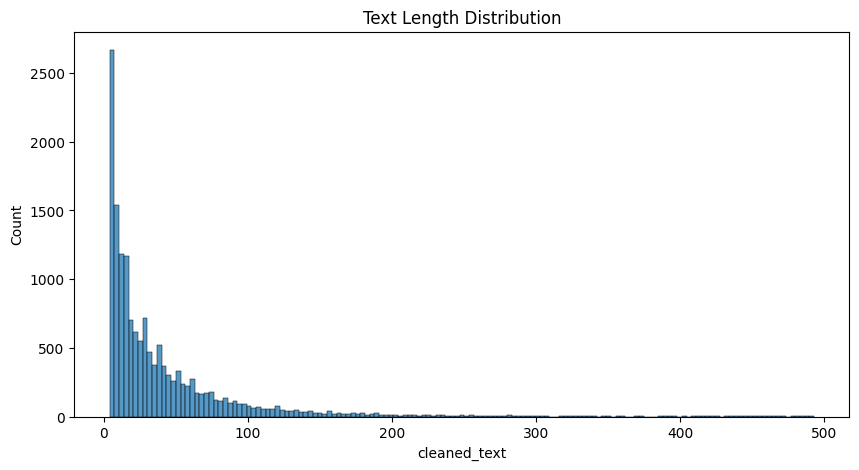

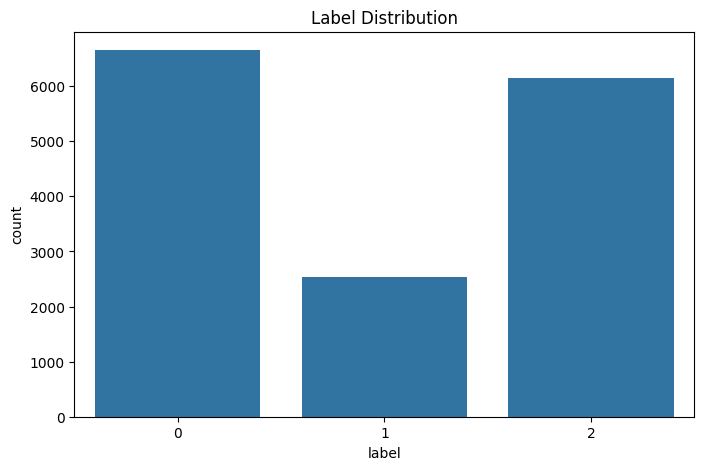

In [29]:
# Phân tích độ dài văn bản
plt.figure(figsize=(10, 5))
text_lengths = processed_df['cleaned_text'].str.len()
sns.histplot(text_lengths)
plt.title('Text Length Distribution')
plt.show()

# Phân tích phân phối nhãn
plt.figure(figsize=(8, 5))
sns.countplot(data=processed_df, x='label')
plt.title('Label Distribution')
plt.show()

## 4. Feature Engineering

In [30]:
# Extract features
X_train_features = feature_extractor.extract_features(X_train)
X_test_features = feature_extractor.extract_features(X_test)

print("Feature shapes:")
print(f"Training features: {X_train_features.shape}")
print(f"Testing features: {X_test_features.shape}")

Word features shape: (10741, 2000)
Char features shape: (10741, 500)
Tfidf features shape: (10741, 2000)
Linguistic features shape: (10741, 6)
Emotion features shape: (10741, 15)
All features shape after hstack: (10741, 4521)
Word features shape: (4604, 2000)
Char features shape: (4604, 500)
Tfidf features shape: (4604, 2000)
Linguistic features shape: (4604, 6)
Emotion features shape: (4604, 15)
All features shape after hstack: (4604, 4521)
Feature shapes:
Training features: (10741, 4521)
Testing features: (4604, 4521)


## 5. Training Model

In [31]:
# Train models
models = model_trainer.train_with_grid_search(X_train, y_train)

# Get best model performance
best_model_name = max(models.items(), key=lambda x: getattr(x[1], 'best_score_', 0))[0]
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Best score: {getattr(best_model, 'best_score_', 0):.4f}")

2024-11-17 14:24:29,556 - src.models.model_trainer - INFO - Starting model training...
2024-11-17 14:24:29,556 - src.models.model_trainer - INFO - Starting model training...
2024-11-17 14:24:29,556 - src.models.model_trainer - INFO - Starting model training...
Loaded feature extractor with None dimensions
Word features shape: (10741, 2000)
Char features shape: (10741, 500)
Tfidf features shape: (10741, 2000)
Linguistic features shape: (10741, 6)
Emotion features shape: (10741, 15)
All features shape after hstack: (10741, 4521)
Word features shape: (10741, 2000)
Char features shape: (10741, 500)
Tfidf features shape: (10741, 2000)
Linguistic features shape: (10741, 6)
Emotion features shape: (10741, 15)
All features shape after hstack: (10741, 4521)
2024-11-17 14:24:34,243 - src.models.model_trainer - INFO - 
Training rf model...
2024-11-17 14:24:34,243 - src.models.model_trainer - INFO - 
Training rf model...
2024-11-17 14:24:34,243 - src.models.model_trainer - INFO - 
Training rf mode

## 6. Đánh giá Model

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1996
           1       0.33      0.27      0.30       761
           2       0.81      0.77      0.79      1847

    accuracy                           0.69      4604
   macro avg       0.61      0.61      0.61      4604
weighted avg       0.68      0.69      0.69      4604



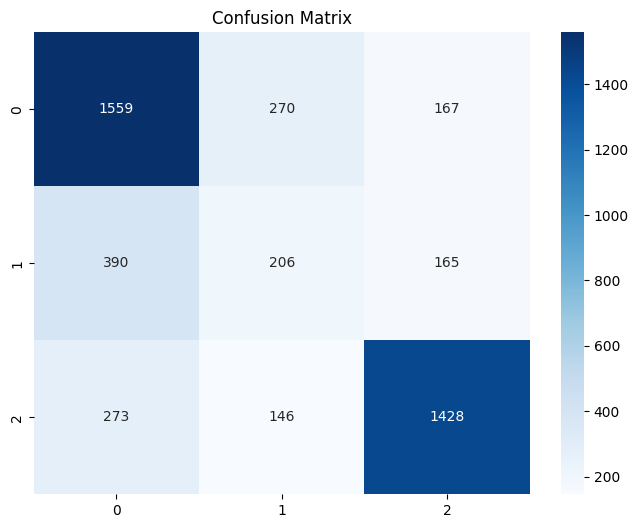

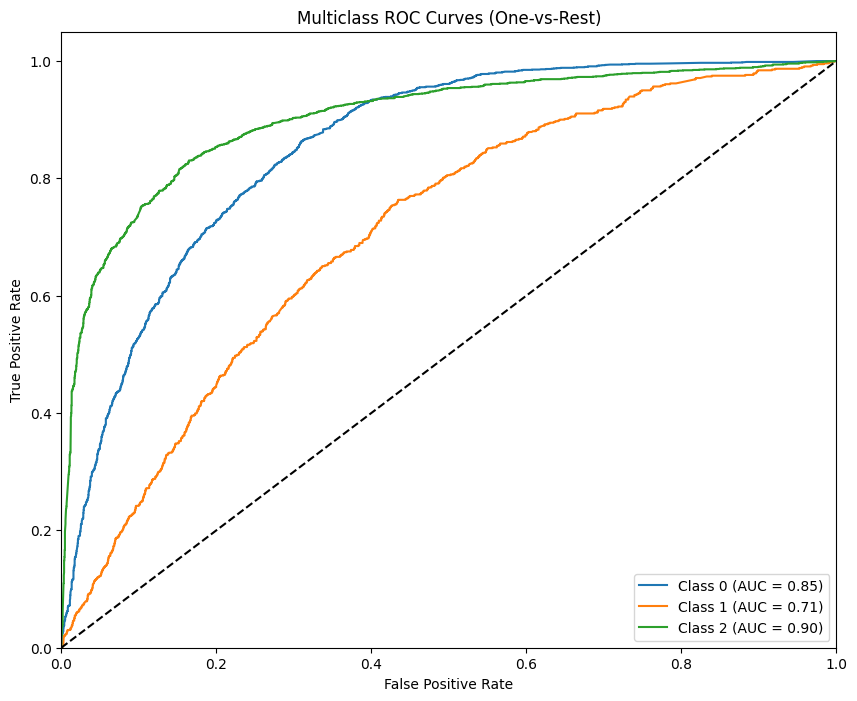

In [32]:
# Initialize predictor
predictor = SentimentPredictor(language, config)

# Make predictions
predictions = predictor.predict(X_test_features)
probabilities = predictor.predict_proba(X_test_features)

# Modified evaluation code to handle multiclass
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np

# Basic metrics
results = {
    'classification_report': classification_report(y_test, predictions),
    'confusion_matrix': confusion_matrix(y_test, predictions)
}

# Display results
print("Classification Report:")
print(results['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curves for each class
n_classes = probabilities.shape[1]
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    # Convert to one-vs-rest binary format
    y_test_binary = (y_test == i).astype(int)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

## 7. Thử nghiệm Model

In [33]:
# Test with sample texts
test_texts = [
    "Sản phẩm rất tốt, tôi rất thích",
    "Chất lượng kém, không đáng tiền",
    "Tạm được, không tốt không xấu"
]

# Process and predict
for text in test_texts:
    # Preprocess
    df = pd.DataFrame({'text': [text]})
    processed = preprocessor.preprocess(df)
    
    # Extract features
    features = feature_extractor.extract_features(processed['cleaned_text'])
    
    # Get prediction with emotion
    result = predictor.predict_emotion(features, text)
    
    # Display results
    print(f"\nText: {text}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['sentiment_confidence']:.4f}")
    print(f"Emotion: {result['emotion']} ({result['emotion_vi']}) {result['emotion_emoji']}")

2024-11-17 14:28:40,403 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-17 14:28:40,403 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-17 14:28:40,403 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-17 14:28:40,408 - src.data.preprocessor - INFO - Preprocessed 1 valid samples
2024-11-17 14:28:40,408 - src.data.preprocessor - INFO - Preprocessed 1 valid samples
2024-11-17 14:28:40,408 - src.data.preprocessor - INFO - Preprocessed 1 valid samples
Word features shape: (1, 2000)
Char features shape: (1, 500)
Tfidf features shape: (1, 2000)
Linguistic features shape: (1, 6)
Emotion features shape: (1, 15)
All features shape after hstack: (1, 4521)

Text: Sản phẩm rất tốt, tôi rất thích
Sentiment: 2
Confidence: 0.9459
Emotion: happy (vui vẻ) 😊
2024-11-17 14:28:40,438 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-17 14:28:40,438 - src.data.preprocessor - INFO - Preprocessing vi data...
2024-11-17 14:28:40,438 - src.dat

## 8. Phân tích Hiệu năng chi tiết

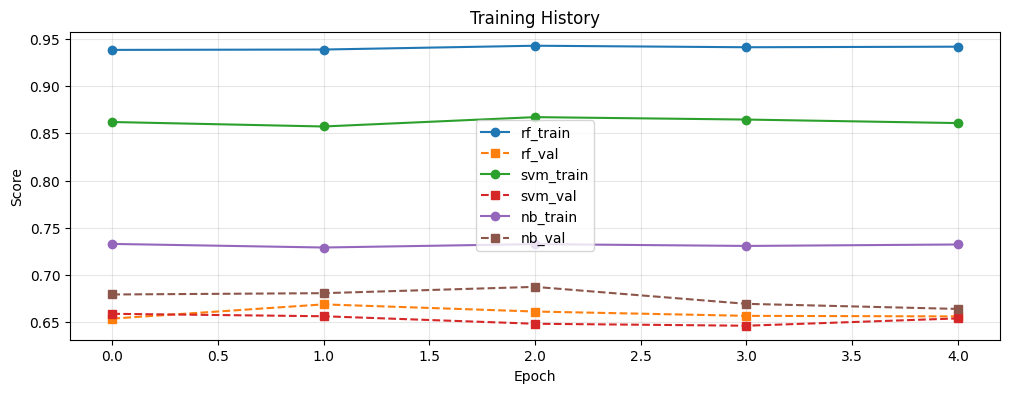

In [34]:
# Lấy metrics từ model_info
model_path = os.path.join(config.DATA_DIR, "models", f"{language}_sentiment_model.pkl")
model_info = joblib.load(model_path)
metrics = model_info['metrics']

# Hiển thị training history
if 'training_history' in metrics:
    plt.figure(figsize=(12, 4))
    for model_name, history in metrics['training_history'].items():
        plt.plot(history['train_scores'], 'o-', label=f'{model_name}_train')
        plt.plot(history['valid_scores'], 's--', label=f'{model_name}_val')
    
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Hiển thị feature importance nếu có
if 'rf' in models and hasattr(models['rf'], 'feature_importances_'):
    importances = models['rf'].feature_importances_
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(importances)), importances)
    plt.title('Feature Importance')
    plt.show()